In [1]:
import numpy as np
import torch
from torch import nn

import nflows
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.coupling import AdditiveCouplingTransform, AffineCouplingTransform
from nflows.transforms.base import CompositeTransform
import matplotlib.pyplot as plt

from neulat.action import Phi4Action
from loss import ReparamKL
from neulat.models import Z2Nice, COUPLINGS

from tqdm import tqdm

import matplotlib.pyplot as plt 

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
T, L = 16, 8
lattice_shape = (T,L)

In [4]:
kappa = 0.3
lambd = 0.022
phi4_action = Phi4Action(kappa, lambd)

### Define flow in nflows

In [5]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker

In [6]:
make_checker_mask(lattice_shape, 0)

tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)

In [7]:
def make_mask(lattice_shape, parity):
    """
    Input: B x T, flattened 8*8
    """
    mask = make_checker_mask(lattice_shape, parity)
    return mask.flatten()

In [8]:
make_mask(lattice_shape, 0) + make_mask(lattice_shape, 1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8)

In [9]:
class Net(nn.Module):
    def __init__(self, num_id, num_trf) -> None:
        super().__init__()
        mid_dim=1000
        nblocks=4

        self.net = nn.Sequential(
            nn.Linear(num_id, mid_dim, bias=False),
            nn.Tanh(),
            nn.Sequential(*[
                nn.Sequential(
                    nn.Linear(mid_dim, mid_dim, bias=False),
                    nn.Tanh(),
                ) for _ in range(nblocks)
            ]),
            nn.Linear(mid_dim, num_trf, bias=False)
        )
    
    def forward(self, x, ctx):
        return self.net(x)

In [10]:
class Z2NICE(AdditiveCouplingTransform):
    def __init__(self, mask, transform_net_create_fn, unconditional_transform=None, scale_activation=...):
        super().__init__(mask, transform_net_create_fn, unconditional_transform, scale_activation)

        self.scale = nn.Parameter(
            torch.zeros((1, torch.tensor(list(lattice_shape)).prod()//2)),
            requires_grad=True
        )

    def _scale_and_shift(self, transform_params):
        shift = transform_params
        scale = torch.exp(self.scale)
        return scale, shift

In [11]:
num_layers = 6
base_dist = StandardNormal(shape=[128]).to(device)

transforms = []
for i in range(num_layers):
    transforms.append(
        Z2NICE(
            make_mask(lattice_shape, i % 2), 
            Net
        ),
    )
transform = CompositeTransform(transforms)

flow_nflows = Flow(transform, base_dist)

In [12]:
coupling_factory = COUPLINGS["checkerfc"]
flow_neulat = Z2Nice(
    lat_shape=lattice_shape,
    coupling_factory=coupling_factory,
    ncouplings=6,
    nblocks=4,
    global_scaling=False
)

### Training

In [13]:
flow = flow_nflows
flow = flow.to(device)

In [14]:
kl_loss = ReparamKL(
    model=flow, 
    action=phi4_action, 
    lat_shape=lattice_shape,
    batch_size=8_000
)

In [15]:
def train_step(model, action, optimizer, batch_size):
    
    optimizer.zero_grad()

    loss, loss_summands, actions = kl_loss()
    
    loss.backward()
    optimizer.step()
    
    print("loss", loss.cpu().item())

    return loss.cpu().item()

In [16]:
optimizer = torch.optim.AdamW(flow.parameters(), lr=5e-4, amsgrad=True)
losses = []
for epoch in range(1_001):
    print(epoch)
    loss = train_step(flow_nflows, phi4_action, optimizer, 8_000)
    losses.append(loss)

0
loss -50.65690231323242
1
loss -64.69991302490234
2
loss -73.56086730957031
3
loss -77.72943878173828
4
loss -78.57081604003906
5
loss -75.645263671875
6
loss -59.01939392089844
7
loss -78.68744659423828
8
loss -77.20210266113281
9
loss -78.04595947265625
10
loss -78.58914184570312
11
loss -78.75914001464844
12
loss -78.97647857666016
13
loss -79.25819396972656
14
loss -79.64715576171875
15
loss -80.17517852783203
16
loss -80.82732391357422
17
loss -81.39418029785156
18
loss -81.78976440429688
19
loss -82.59349060058594
20
loss -83.22442626953125
21
loss -83.63312530517578
22
loss -84.19696807861328
23
loss -85.04672241210938
24
loss -85.97635650634766
25
loss -87.14363098144531
26
loss -89.2485580444336
27
loss -90.44384765625
28
loss -87.24166107177734
29
loss -82.96324157714844
30
loss -90.07709503173828
31
loss -87.88536071777344
32
loss -88.30278778076172
33
loss -89.4909439086914
34
loss -90.41934967041016
35
loss -91.40275573730469
36
loss -93.29866027832031
37
loss -94.101051

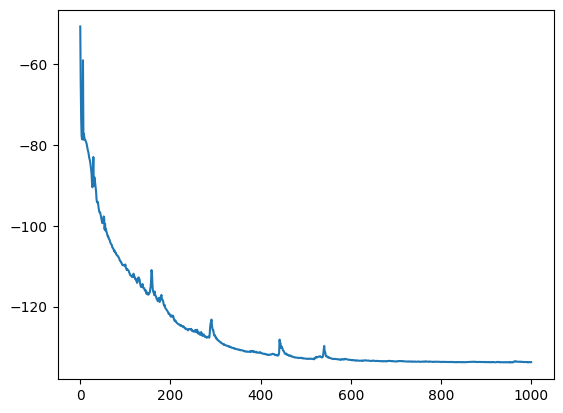

In [17]:
plt.plot(losses)

In [18]:
torch.save(flow.state_dict(), "model_nflows.pth")